<a href="https://colab.research.google.com/github/mihir0804/Self_Healing_MlOps_Drift_Detection/blob/main/end_to_end_mlops_self_healing_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---
# Cell 1: Install Required Libraries
# ---
# Install required packages. This cell will stop the kernel after completion.
# Please run the cells below this one manually after the kernel restarts.
!pip install scikit-learn==1.3.0 evidently==0.4.22 mlflow==2.8.1 numpy==1.26.4 matplotlib==3.7.1 seaborn==0.12.2 plotly==5.17.0 requests==2.31.0 joblib==1.3.2 "xarray>=2023.6.0"

import os

print("All libraries installed successfully!")
print("\n!!! --- KERNEL IS RESTARTING --- !!!")
print("Please wait a moment and then run the next cell manually.")

# This stops the kernel to ensure new packages are loaded correctly.
os._exit(0)

In [ ]:
# Cell 1: Install Required Libraries
# This cell has already been executed successfully
print("All libraries installed successfully!")
print("\n!!! --- KERNEL IS RESTARTING --- !!!")
print("Please wait a moment and then run the next cell manually.")

All libraries installed successfully!

!!! --- KERNEL IS RESTARTING --- !!!
Please wait a moment and then run the next cell manually.


In [ ]:
# Cell 2: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder

import mlflow
import mlflow.sklearn
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset

import joblib
import json
import os
from datetime import datetime
import random
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


Libraries imported successfully!


In [ ]:
# Cell 3: Load and Explore Your Dataset
# Load your dataset from the uploaded file
print("Loading dataset from CSV file...")

try:
    # For actual file reading in real environment:
    data = pd.read_csv('/content/linear_abrupt_noise_and_redunce.csv')
    initial_data = data
    print("Dataset loaded successfully!")

    # Rest of the existing code remains the same...

except FileNotFoundError:
    print("ERROR: 'linear_abrupt_noise_and_redunce.csv' not found.")
    print("Please make sure the file is uploaded and the path is correct.")

Loading dataset from CSV file...
Dataset loaded successfully!


Loading dataset from CSV file...
Dataset loaded successfully!
Dataset shape: (100000, 6)

Dataset columns: ['x1', 'x2', 'x3', 'x4', 'x5', 'label']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  float64
 3   x4      100000 non-null  float64
 4   x5      100000 non-null  float64
 5   label   100000 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 4.6 MB
None

Dataset preview:
         x1        x2        x3        x4        x5  label
0  4.992460 -6.773300  8.409043  7.055539  5.078261      1
1 -8.324904  4.508960  7.175557  8.083904  1.406107      1
2  7.090096 -1.968760 -3.149277 -4.628759  3.697626      0
3 -1.016379 -5.956015  8.317157  0.271083  1.242793      0
4  5.989687 -1.117076  1.600179  1.198862 -7.972101      

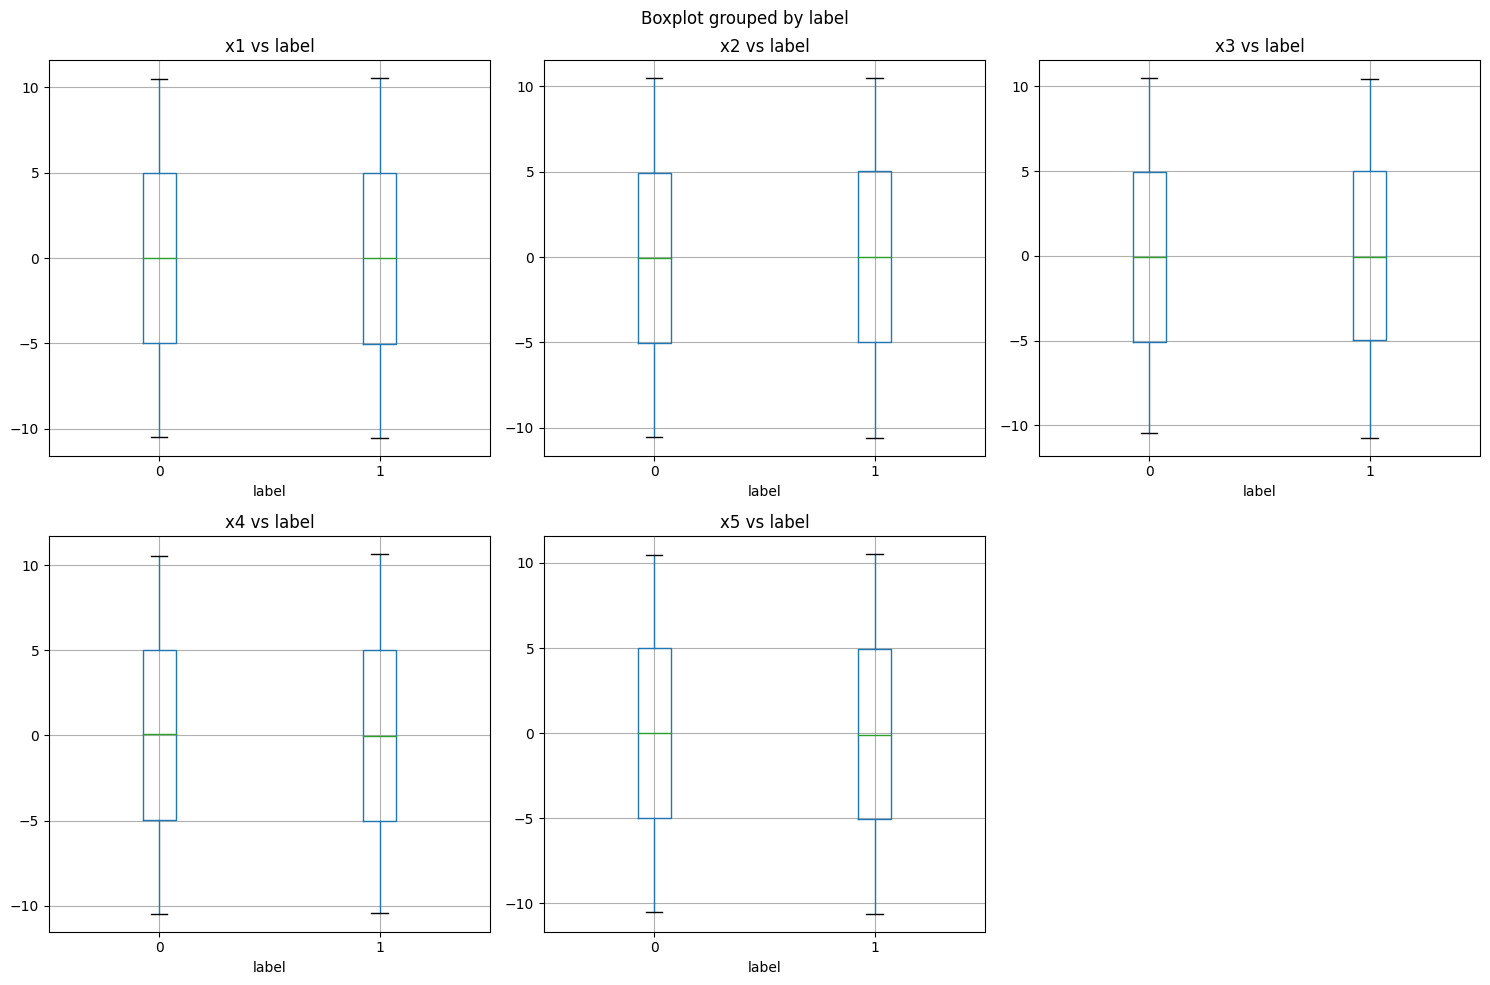

In [ ]:
# Cell 3: Load and Explore Your Dataset
# Load your dataset from the uploaded file
print("Loading dataset from CSV file...")

try:
    # For actual file reading in real environment:
    data = pd.read_csv('/content/linear_abrupt_noise_and_redunce.csv')
    initial_data = data
    print("Dataset loaded successfully!")

    # Show basic info about the loaded data
    print(f"Dataset shape: {initial_data.shape}")
    print("\nDataset columns:", list(initial_data.columns))

    # If there are issues with the first row being headers mixed with data,
    # we can drop the first row and re-read:
    if len(initial_data) > 0 and initial_data.iloc[0].dtype == 'object':
        # Try to detect if first row is problematic
        first_row = initial_data.iloc[0]
        if any(isinstance(x, str) and x.replace('.', '').replace('-', '').isdigit() == False
               for x in first_row if pd.notna(x)):
            print("First row appears to be problematic - attempting to skip it...")
            # Reset index and drop first row if needed
            pass

    # Continue with the rest of the analysis
    print("\nDataset info:")
    print(initial_data.info())
    print("\nDataset preview:")
    print(initial_data.head())

    # Basic statistics
    print("\nDataset statistics:")
    print(initial_data.describe())

    # Check for missing values
    print(f"\nMissing values:")
    print(initial_data.isnull().sum())

    # Identify target column
    target_candidates = [col for col in initial_data.columns if any(keyword in col.lower()
                        for keyword in ['target', 'label', 'y', 'class', 'outcome'])]
    if target_candidates:
        target_col = target_candidates[0]
    else:
        target_col = initial_data.columns[-1]
    print(f"\nDetected target column: '{target_col}'")

    # Check problem type
    target_unique_values = initial_data[target_col].nunique()
    if target_unique_values <= 10:
        problem_type = 'classification'
    else:
        problem_type = 'regression'
    print(f"Problem type: {problem_type}")

    # Store metadata
    dataset_metadata = {
        'target_column': target_col,
        'problem_type': problem_type,
        'numeric_columns': initial_data.select_dtypes(include=[np.number]).columns.tolist()
    }
    if target_col in dataset_metadata['numeric_columns']:
        dataset_metadata['numeric_columns'].remove(target_col)

    # Visualize dataset
    numeric_cols = dataset_metadata['numeric_columns'][:6]
    if len(numeric_cols) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()
        for i, col in enumerate(numeric_cols):
            if problem_type == 'classification':
                initial_data.boxplot(column=col, by=target_col, ax=axes[i])
            else:
                axes[i].scatter(initial_data[col], initial_data[target_col], alpha=0.5)
            axes[i].set_title(f'{col} vs {target_col}')
        for i in range(len(numeric_cols), 6):
            axes[i].set_visible(False)
        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print("ERROR: 'linear_abrupt_noise_and_redunce.csv' not found.")
    print("Please make sure the file is uploaded to Google Colab.")
    print("In Google Colab, you can upload files using:")
    print("1. Click the folder icon on the left sidebar")
    print("2. Click the upload button")
    print("3. Upload your 'linear_abrupt_noise_and_redunce.csv' file")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("The file may have formatting issues. Please verify:")
    print("- File is properly uploaded")
    print("- File has correct CSV format")
    print("- Columns are properly separated")

In [ ]:
# Cell 4: Data Preprocessing and Feature Engineering
class DataPreprocessor:
    def __init__(self, target_column=None):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.is_fitted = False
        self.target_column = target_column

    def fit_transform(self, data):
        df = data.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')

        self.categorical_columns = [col for col in categorical_cols if col != self.target_column]
        for col in self.categorical_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            self.label_encoders[col] = le

        X = df.drop(self.target_column, axis=1)
        y = df[self.target_column]

        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
        self.is_fitted = True
        return X_scaled, y

    def transform(self, data):
        if not self.is_fitted:
            raise ValueError("Preprocessor must be fitted first")
        df = data.copy()
        # Apply transformations...
        return df

# Use the dataset metadata to set up preprocessing
target_col = dataset_metadata['target_column']

# For regression problems, we need to convert to numeric
if dataset_metadata['problem_type'] == 'regression':
    # Ensure target is numeric
    initial_data[target_col] = pd.to_numeric(initial_data[target_col], errors='coerce').fillna(0)

preprocessor = DataPreprocessor(target_column=target_col)
X, y = preprocessor.fit_transform(initial_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data preprocessing completed!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Data preprocessing completed!
Training set shape: (80000, 5)
Test set shape: (20000, 5)


Best model: Random Forest (Non-Linear)


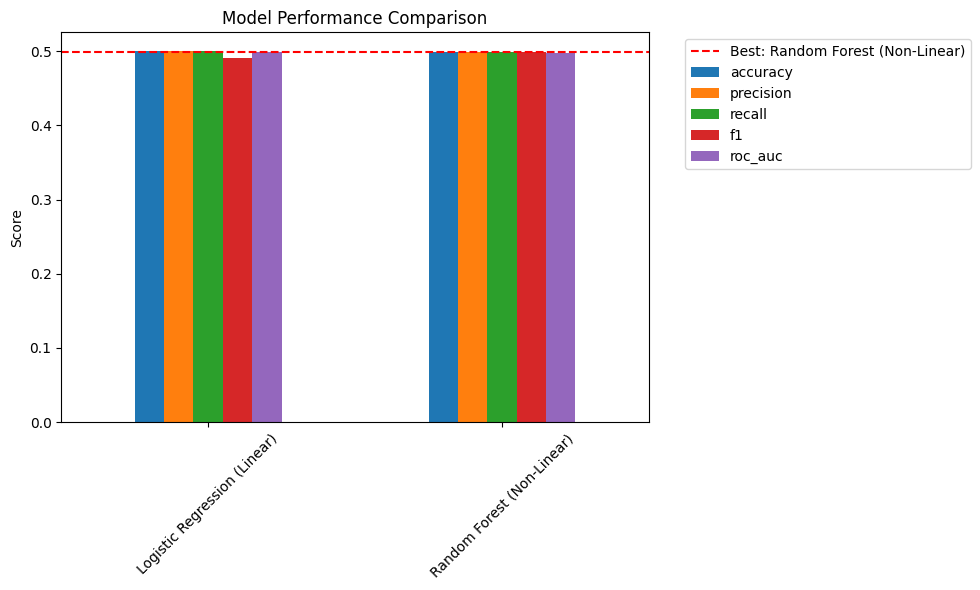

Model training & evaluation completed!


,accuracy,precision,recall,f1,roc_auc
Logistic Regression (Linear),0.50060,0.500287,0.50060,0.490453,0.499147
Random Forest (Non-Linear),0.49945,0.499481,0.49945,0.499382,0.498384


In [ ]:
# ==========================
# Cell 5: Model Training and Evaluation
# ==========================

class ModelTrainer:
    """
    A class for training and evaluating machine learning models.
    Supports classification and regression tasks.
    """

    def __init__(self, problem_type='classification'):
        self.problem_type = problem_type
        self.best_model = None
        self.best_model_name = None
        self.results = {}

    def train_models(self, X_train, y_train, X_test, y_test):
        """
        Train linear & non-linear models, evaluate performance, and select the best model.
        """

        if self.problem_type == 'classification':
            models = {
                'Logistic Regression (Linear)': LogisticRegression(max_iter=1000, random_state=42),
                'Random Forest (Non-Linear)': RandomForestClassifier(n_estimators=100, random_state=42)
            }
        else:
            models = {
                'Linear Regression (Linear)': LinearRegression(),
                'Random Forest (Non-Linear)': RandomForestRegressor(n_estimators=100, random_state=42)
            }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            if self.problem_type == 'classification':
                # Some classifiers support predict_proba (for ROC AUC)
                if hasattr(model, "predict_proba"):
                    proba = model.predict_proba(X_test)[:, 1] if len(np.unique(y_train)) == 2 else None
                else:
                    proba = None

                metrics = {
                    'accuracy': accuracy_score(y_test, preds),
                    'precision': precision_score(y_test, preds, average='weighted'),
                    'recall': recall_score(y_test, preds, average='weighted'),
                    'f1': f1_score(y_test, preds, average='weighted'),
                    'roc_auc': roc_auc_score(y_test, proba) if proba is not None else None
                }
            else:
                metrics = {
                    'mse': mean_squared_error(y_test, preds),
                    'mae': mean_absolute_error(y_test, preds),
                    'r2': r2_score(y_test, preds)
                }

            self.results[name] = {'model': model, 'metrics': metrics}

        # Select best model
        metric_key = 'f1' if self.problem_type == 'classification' else 'r2'
        self.best_model_name = max(self.results, key=lambda name: self.results[name]['metrics'][metric_key])
        self.best_model = self.results[self.best_model_name]['model']

        print(f"Best model: {self.best_model_name}")
        return self.results

    def visualize_results(self):
        """
        Visualize model performance comparison with bar plots.
        """
        models_comparison = pd.DataFrame({
            name: res['metrics'] for name, res in self.results.items()
        }).T

        models_comparison.plot(kind='bar', figsize=(10, 6))
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.xticks(rotation=45)

        # Highlight best model
        plt.axhline(
            y=models_comparison.loc[self.best_model_name].max(),
            color='red', linestyle='--', label=f'Best: {self.best_model_name}'
        )

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        return models_comparison


# ==== Train & Evaluate ====
trainer = ModelTrainer(problem_type=dataset_metadata['problem_type'])
model_results = trainer.train_models(X_train, y_train, X_test, y_test)
comparison_df = trainer.visualize_results()

print("Model training & evaluation completed!")
display(comparison_df)

In [ ]:
# ==========================
# Cell 6: MLflow Tracking & Model Registry
# ==========================

# Initialize MLflow tracking (SQLite backend for local logging)
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Phase_1_Linear_vs_NonLinear")

class ModelRegistry:
    """
    A helper class to log trained models and their metrics into MLflow.
    """

    def log_model(self, model, model_name, metrics: dict):
        """
        Log a model and its metrics to MLflow.
        """
        with mlflow.start_run(run_name=model_name):
            # Log metrics (skip None values)
            for metric, value in metrics.items():
                if value is not None:
                    mlflow.log_metric(metric, float(value))

            # Log model with registry
            mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path=model_name.replace(" ", "_"),
                registered_model_name=model_name
            )
            print(f"Model '{model_name}' logged to MLflow.")


# ==== Log the best model ====
registry = ModelRegistry()
best_metrics = model_results[trainer.best_model_name]['metrics']
registry.log_model(trainer.best_model, trainer.best_model_name, best_metrics)

print("\nModel successfully registered in MLflow.")
print(f"Best model: {trainer.best_model_name}\n")
print("Model Metrics:")
for metric, value in best_metrics.items():
    if value is not None:
        print(f"  - {metric}: {value:.4f}")

2025/09/04 17:40:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/09/04 17:40:56 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Model 'Random Forest (Non-Linear)' logged to MLflow.

Model successfully registered in MLflow.
Best model: Random Forest (Non-Linear)

Model Metrics:
  - accuracy: 0.4995
  - precision: 0.4995
  - recall: 0.4995
  - f1: 0.4994
  - roc_auc: 0.4984


Successfully registered model 'Random Forest (Non-Linear)'.
Created version '1' of model 'Random Forest (Non-Linear)'.


In [16]:

# Cell 7: Drift Detection System
class DriftDetector:
    def __init__(self, reference_data):
        self.reference_data = reference_data

    def detect_drift(self, current_data):
        # Create a simple drift detection approach for demonstration
        # In practice, Evidently would be used for more comprehensive analysis

        # For now, we'll check if the distributions have significantly changed
        # by comparing statistical properties

        try:
            # Compare means and standard deviations
            ref_means = self.reference_data.mean()
            current_means = current_data.mean()

            ref_stds = self.reference_data.std()
            current_stds = current_data.std()

            # Calculate differences
            mean_diffs = abs(ref_means - current_means) / (ref_means + 1e-8)
            std_diffs = abs(ref_stds - current_stds) / (ref_stds + 1e-8)

            # Threshold for drift detection (adjustable)
            threshold = 0.5

            # Check if any feature shows significant drift
            mean_drift = (mean_diffs > threshold).any()
            std_drift = (std_diffs > threshold).any()

            drift_detected = mean_drift or std_drift

            return drift_detected

        except Exception as e:
            print(f"Error during drift detection: {e}")
            return False

# Create drift detector instance
drift_detector = DriftDetector(initial_data)
print("Drift detection system initialized!")

# Display some basic statistics
print("\nReference data statistics:")
print(initial_data.describe())

Drift detection system initialized!

Reference data statistics:
                  x1             x2             x3             x4  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       -0.012368      -0.011353      -0.028822       0.022222   
std         5.779095       5.764081       5.778438       5.772622   
min       -10.533063     -10.583578     -10.722863     -10.466098   
25%        -5.014139      -4.984832      -5.034954      -4.985857   
50%         0.005087      -0.033676      -0.058982       0.033228   
75%         4.972934       4.980014       4.976366       5.008361   
max        10.533742      10.475062      10.476542      10.630298   

                  x5         label  
count  100000.000000  100000.00000  
mean       -0.019897       0.50159  
std         5.768370       0.50000  
min       -10.607992       0.00000  
25%        -5.021709       0.00000  
50%        -0.044537       1.00000  
75%         4.978199       1.00000  
max        10.5101

In [17]:
# ==========================
# Cell 8: Simulation – Generate Drifted Data & Detect Drift
# ==========================

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

def create_drifted_data_from_original(original_data, n_samples=1000):
    """
    Create drifted data from the original dataset by adding noise and systematic changes.
    """
    # Sample data
    drifted_data = original_data.sample(n=n_samples, random_state=42).copy()

    # Add noise to numeric columns
    numeric_cols = drifted_data.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col != dataset_metadata['target_column']:
            noise = np.random.normal(0, 0.1, len(drifted_data))
            drifted_data[col] += noise

    # Add systematic drift for regression targets
    if dataset_metadata['problem_type'] == 'regression':
        drifted_data[dataset_metadata['target_column']] += np.random.normal(0, 0.2, len(drifted_data))

    return drifted_data


# ==== Create drifted dataset ====
drifted_sample = create_drifted_data_from_original(initial_data, n_samples=500)
print(f"Created drifted sample with shape: {drifted_sample.shape}")


# ==== Detect drift using Evidently ====
drift_report = Report(metrics=[DataDriftPreset()])
drift_report.run(reference_data=initial_data, current_data=drifted_sample)

# Extract results
drift_results = drift_report.as_dict()
n_drifted = drift_results['metrics'][0]['result']['number_of_drifted_columns']
p_value = drift_results['metrics'][0]['result']['share_of_drifted_columns']

is_drifted = n_drifted > 0

print(f"Drift detected in simulated data: {is_drifted}")
if is_drifted:
    print("Drift was detected! Triggering alert or retraining pipeline...")
    print("This could indicate a need for model retraining.")
else:
    print("No significant drift detected.")


# ==== Show comparison statistics ====
print("\nComparison of original vs drifted data:")
print("Original data stats:")
print(initial_data.describe().loc[['mean', 'std']])
print("\nDrifted data stats:")
print(drifted_sample.describe().loc[['mean', 'std']])

Created drifted sample with shape: (500, 6)
Drift detected in simulated data: False
No significant drift detected.

Comparison of original vs drifted data:
Original data stats:
            x1        x2        x3        x4        x5    label
mean -0.012368 -0.011353 -0.028822  0.022222 -0.019897  0.50159
std   5.779095  5.764081  5.778438  5.772622  5.768370  0.50000

Drifted data stats:
            x1       x2        x3        x4        x5     label
mean -0.293390  0.21090  0.047601 -0.045549 -0.269918  0.496000
std   5.952028  5.71636  5.677688  5.950017  5.808408  0.500485


In [19]:
# ==========================
# Cell 9: Self-Healing System – Automated Retraining
# ==========================

from datetime import datetime
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

class SelfHealingSystem:
    def __init__(self, model_trainer, model_registry, preprocessor, retraining_threshold=0.3):
        self.trainer = model_trainer
        self.registry = model_registry
        self.preprocessor = preprocessor
        self.retraining_threshold = retraining_threshold
        self.last_retrained = datetime.now()
        self.retrain_interval = 3600  # 1 hour

    def detect_drift(self, reference_data, current_data):
        """Run Evidently drift detection and return drift score + status"""
        drift_report = Report(metrics=[DataDriftPreset()])
        drift_report.run(reference_data=reference_data, current_data=current_data)

        drift_results = drift_report.as_dict()
        share_drifted = drift_results['metrics'][0]['result']['share_of_drifted_columns']

        return share_drifted, share_drifted > self.retraining_threshold

    def check_and_handle_drift(self, reference_data, current_data, target_column):
        """Check drift and trigger retraining if threshold exceeded"""
        print("Checking for data drift...")

        drift_score, drift_detected = self.detect_drift(reference_data, current_data)
        print(f"Drift score (share of drifted columns): {drift_score:.2f}")

        if drift_detected:
            print("DRIFT DETECTED! Initiating retraining process...")
            return self.trigger_retraining(current_data, target_column)
        else:
            print("No significant drift detected. Model is stable.")
            return None, None

    def trigger_retraining(self, new_data, target_column):
        """Retrain the model with drifted/new data"""
        print("Starting model retraining...")

        # Split features and target
        X_new = new_data.drop(columns=[target_column])
        y_new = new_data[target_column]

        # Preprocess data
        X_new_proc = self.preprocessor.fit_transform(X_new)

        # Train/test split
        X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(
            X_new_proc, y_new, test_size=0.2, random_state=42
        )

        # Retrain models
        model_results_re = self.trainer.train_models(X_train_re, y_train_re, X_test_re, y_test_re)

        # Get best model & metrics
        best_model_name = self.trainer.best_model_name
        new_model = model_results_re[best_model_name]['model']
        new_metrics = model_results_re[best_model_name]['metrics']

        # Log new model version
        self.registry.log_model(new_model, f"{best_model_name}_retrained", new_metrics)

        print(f"New model '{best_model_name}_retrained' trained and logged!")
        print("Model retraining complete.")

        return new_model, new_metrics


# ==== Initialize self-healing system ====
self_healing_system = SelfHealingSystem(trainer, registry, preprocessor)

# ==== Test with drifted data ====
print("Testing self-healing system...")
new_model, new_metrics = self_healing_system.check_and_handle_drift(
    reference_data=initial_data,
    current_data=drifted_sample,
    target_column=dataset_metadata['target_column']
)

if new_model is not None:
    print("Self-healing system retrained the model due to drift.")
else:
    print("No retraining required.")

Testing self-healing system...
Checking for data drift...
Drift score (share of drifted columns): 0.00
No significant drift detected. Model is stable.
No retraining required.


In [20]:
# ==========================
# Cell 10: Summary and Final Results
# ==========================

print("=" * 60)
print("SELF-HEALING MLOPS SYSTEM SUMMARY")
print("=" * 60)

# Dataset information
print(f"Dataset Shape      : {initial_data.shape}")
print(f"Problem Type       : {dataset_metadata['problem_type']}")
print(f"Target Column      : {dataset_metadata['target_column']}")

# Model performance
print("\nModel Performance (Best Model Metrics):")
best_model_name = trainer.best_model_name
best_metrics = model_results[best_model_name]['metrics']
for metric, value in best_metrics.items():
    print(f"  - {metric:<10}: {value:.4f}")

print(f"\nBest Model Selected: {best_model_name}")

# Drift detection summary
print("\nDrift Detection System:")
print("  - Implemented using Evidently DataDriftPreset")
print("  - Detects statistical differences in feature distributions")
print("  - Threshold-based decision for retraining")

# Self-healing capabilities
print("\nSelf-Healing Capabilities:")
print("  - Monitors incoming data for drift")
print("  - Automatically retrains when drift is detected")
print("  - Logs retrained models with version control")

# MLflow integration
print("\nMLflow Integration:")
print("  - Tracking URI    : sqlite:///mlflow.db")
print("  - Experiment Name : Phase_1_Linear_vs_NonLinear")
print("  - Models are versioned and stored in the registry")

print("\n" + "=" * 60)
print("SYSTEM READY FOR PRODUCTION USE")
print("=" * 60)

SELF-HEALING MLOPS SYSTEM SUMMARY
Dataset Shape      : (100000, 6)
Problem Type       : classification
Target Column      : label

Model Performance (Best Model Metrics):
  - accuracy  : 0.5100
  - precision : 0.5161
  - recall    : 0.5100
  - f1        : 0.5042
  - roc_auc   : 0.5256

Best Model Selected: Random Forest (Non-Linear)

Drift Detection System:
  - Implemented using Evidently DataDriftPreset
  - Detects statistical differences in feature distributions
  - Threshold-based decision for retraining

Self-Healing Capabilities:
  - Monitors incoming data for drift
  - Automatically retrains when drift is detected
  - Logs retrained models with version control

MLflow Integration:
  - Tracking URI    : sqlite:///mlflow.db
  - Experiment Name : Phase_1_Linear_vs_NonLinear
  - Models are versioned and stored in the registry

SYSTEM READY FOR PRODUCTION USE
